# Workflow to calibrate OGGM with geodetic data and run volume projections with your own climate dataset!

- We basically do what `run_prepro_levels` of [prepro_levels.py](https://github.com/lilianschuster/oggm/blob/240ec6001dab28d1f9ac4a684625d4c76ef8369a/oggm/cli/prepro_levels.py) would do if `start_level=2` and if we use `match_geodetic_mb_per_glacier=True`
- here we use the W5E5 climate and a special glacier-specific precipitation factor

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib

import statsmodels as stats
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

cfg.initialize(logging_level='WORKFLOW')
work_dir = utils.gettempdir(dirname='OGGM-geodetic_calib')
cfg.PATHS['working_dir'] = work_dir
sum_dir = work_dir 
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

/home/lilianschuster/oggm/oggm/cfg.py:386: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2022-07-07 10:10:17: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-07-07 10:10:17: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-07-07 10:10:17: oggm.cfg: Multiprocessing: using all available processors (N=8)


### 1. Initialize gdir and process your climate data

In [50]:
cfg.PARAMS['baseline_climate'] = 'GSWP3_W5E5'  # or W5E5 (if you just want data from 1979 onwards!)
cfg.PARAMS['use_winter_prcp_factor'] = True
match_geodetic_mb_per_glacier = True
cfg.PARAMS['climate_qc_months'] = 0
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1

In [3]:
df = ['RGI60-11.00897','RGI60-11.01450']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
#gdir = gdirs[0]
workflow.execute_entity_task(tasks.process_climate_data, gdirs)
# could also use instead directly 
# workflow.execute_entity_task(oggm.shop.w5e5.process_gswp3_w5e5_data, gdirs)


2022-07-07 10:10:18: oggm.workflow: init_glacier_directories from prepro level 2 on 2 glaciers.
2022-07-07 10:10:18: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers
2022-07-07 10:10:18: oggm.workflow: Execute entity tasks [process_climate_data] on 2 glaciers


[None, None]

### 2. calibrate MB model of OGGM with geodetic estimates from Hugonnet et al. (2021)

In [4]:
cfg.PARAMS['temp_melt']

-1.0

In [5]:
cfg.PARAMS['prcp_scaling_factor']  # could change it to : 'from_winter_prcp'  to make that clearer?!

2.5

In [6]:
cfg.PARAMS['temp_all_solid']

0.0

In [7]:
cfg.PARAMS['temp_all_liq']

2.0

In [8]:
cfg.PARAMS['temp_default_gradient']

-0.0065

In [9]:
# actually strange why this is still at 10000 per default even if it means that mu_star_calibration_from_geodetic_mb will not work, maybe change that default value???
cfg.PARAMS['max_mu_star'] = 1000  
# we do not need any climate check!
cfg.PARAMS['climate_qc_months'] = 0
utils.get_geodetic_mb_dataframe()  # Small optim to avoid concurrency


2022-07-07 10:10:28: oggm.cfg: PARAMS['max_mu_star'] changed from `10000.0` to `1000`.


period      area    dmdtda  err_dmdtda  reg  \
rgiid                                                                        
RGI60-01.00001  2000-01-01_2010-01-01  360000.0  0.021700    0.430000    1   
RGI60-01.00001  2000-01-01_2020-01-01  360000.0 -0.012800    0.217600    1   
RGI60-01.00001  2010-01-01_2020-01-01  360000.0 -0.047200    0.394900    1   
RGI60-01.00002  2000-01-01_2010-01-01  558000.0 -0.168300    0.279200    1   
RGI60-01.00002  2000-01-01_2020-01-01  558000.0 -0.229000    0.146000    1   
...                               ...       ...       ...         ...  ...   
RGI60-19.02751  2000-01-01_2020-01-01   11000.0 -0.136311    0.295265   19   
RGI60-19.02751  2010-01-01_2020-01-01   11000.0 -0.119835    0.536447   19   
RGI60-19.02752  2000-01-01_2010-01-01  528000.0  0.121300    0.542100   19   
RGI60-19.02752  2000-01-01_2020-01-01  528000.0 -0.038600    0.289700   19   
RGI60-19.02752  2010-01-01_2020-01-01  528000.0 -0.198500    0.481400   19   

                is_cor  
rgiid                   
RGI60-01.00001   False  
RGI60-01.00001   False  
RGI60-01.00001   False  
RGI60-01.00002   False  
RGI60-01.00002   False  
...                ...  
RGI60-19.02751    True  
RGI60-19.02751    True  
RGI60-19.02752   False  
RGI60-19.02752   False  
RGI60-19.02752   False  

[646641 rows x 6 columns]

In [10]:
# Let's directly calibrate by using prcp. fac from winter prcp. match 
# this is done when switching use_winter_prcp_factor to True in the Params
workflow.execute_entity_task(tasks.mu_star_calibration_from_geodetic_mb, gdirs) #, prcp_fac='from_winter_prcp')


2022-07-07 10:10:28: oggm.cfg: PARAMS['use_winter_prcp_factor'] changed from `False` to `True`.
2022-07-07 10:10:28: oggm.workflow: Execute entity tasks [mu_star_calibration_from_geodetic_mb] on 2 glaciers


[None, None]

**just to visualize what is applied internally in `mu_star_calibration_from_geodetic_mb` if using prcp_fac='from_winter_prcp'**

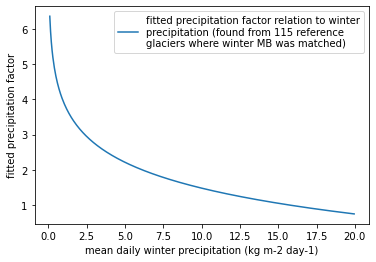

In [55]:
# this is used inside of mu_star_calibration_from_geodetic_mb:
# from MB sandbox calibration to winter MB
# using t_melt=-1, cte lapse rate, monthly resolution
def log_func(x, a, b):
    l0, l1 = cfg.PARAMS['winter_prcp_factor_range']
    a_log_multiplied, b_intercept = cfg.PARAMS['winter_prcp_factor_ab']

    r = a*np.log(x) +b
    # don't allow extremely low/high prcp. factors!!!
    if np.shape(r) == ():
        if r > l1:
            r = l1
        if r< l0:
            r= l0
    else:
        r[r>10] = 10
        r[r<0.1] = 0.1
    return r

winter_prcp_values = np.arange(0.1, 20,0.05)
plt.plot(winter_prcp_values, log_func(winter_prcp_values, a_log_multiplied, b_intercept), label='fitted precipitation factor relation to winter\nprecipitation (found from 115 reference\nglaciers where winter MB was matched)')
plt.ylabel('fitted precipitation factor')
plt.xlabel('mean daily winter precipitation (kg m-2 day-1)') # mean over 1979-2019
plt.legend()

--> **WHAT is done in MB sandbox:**

- a) match winter MB on n=115 reference glaciers and extract from there the relation between calibrated precipitation factor and winter precipitation
- b) different distributions before and after applying the different types of precipitation factor corrections
- c) Wit the logarithmic decrease of the prcp. factor with larger winter prcp., the overall corrected precipitation is less strong for glaciers with a lot of precipitation compared to glaciers with little precipitation

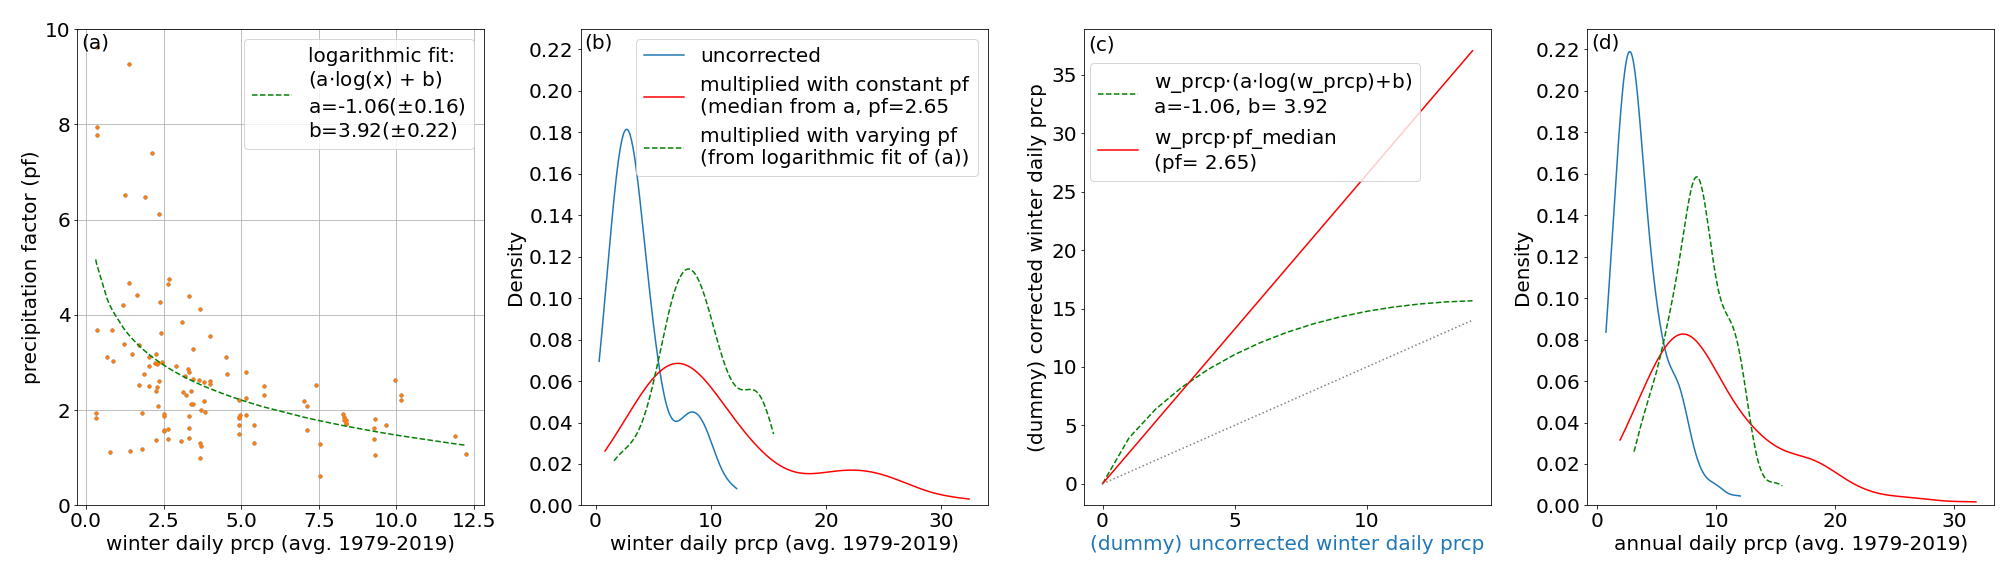

**different prcp. factors were applied depending on the mean daily non-corrected winter prcp**

In [56]:
gdirs[0].read_json('local_mustar')

{'prcp_fac_from_winter_prcp': 3.357136316271367,
 'rgi_id': 'RGI60-11.00897',
 't_star': nan,
 'bias': 0,
 'mu_star_per_flowline': [275.602034813723],
 'mu_star_glacierwide': 275.602034813723,
 'mu_star_flowline_avg': 275.602034813723,
 'mu_star_allsame': True}

In [57]:
gdirs[-1].read_json('local_mustar')

{'prcp_fac_from_winter_prcp': 1.7765151972292408,
 'rgi_id': 'RGI60-11.01450',
 't_star': nan,
 'bias': 0,
 'mu_star_per_flowline': [303.6193835683732],
 'mu_star_glacierwide': 303.6193835683732,
 'mu_star_flowline_avg': 303.6193835683732,
 'mu_star_allsame': True}

In [58]:
# added winter_daily_mean_prcp_1979_2019
clim_stats = utils.compile_climate_statistics(gdirs) #, winter_daily_mean_prcp=True)
fs = '1979-2019'
clim_stats[f'{fs}_uncorrected_winter_daily_mean_prcp'] 

2022-07-07 11:12:46: oggm.utils: Applying global task compile_climate_statistics on 2 glaciers
2022-07-07 11:12:46: oggm.workflow: Execute entity tasks [climate_statistics] on 2 glaciers


rgi_id
RGI60-11.00897    1.6994472904408453
RGI60-11.01450     7.534467999810557
Name: 1979-2019_uncorrected_winter_daily_mean_prcp, dtype: object

In [15]:
clim_stats.T

rgi_id                                            RGI60-11.00897  \
rgi_region                                                    11   
rgi_subregion                                              11-01   
name                                             Hintereisferner   
cenlon                                                   10.7584   
cenlat                                                   46.8003   
rgi_area_km2                                               8.036   
glacier_type                                             Glacier   
terminus_type                                   Land-terminating   
status                                        Glacier or ice cap   
flowline_mean_elev                                   3026.878257   
flowline_max_elev                                    3612.846072   
flowline_min_elev                                    2455.169167   
1980-2010_aar                                           0.514153   
1980-2010_mb_grad                                       9.526522   
1980-2010_ela_h                                      3046.417922   
1980-2010_avg_temp_ela_h                               -5.779841   
1980-2010_avg_temp_mean_elev                           -5.652834   
1980-2010_avg_temp_max_elev                            -9.461624   
1980-2010_avg_temp_min_elev                            -1.936724   
1980-2010_avg_tempmelt_ela_h                            7.624674   
1980-2010_avg_tempmelt_mean_elev                        8.040517   
1980-2010_avg_tempmelt_max_elev                         0.557164   
1980-2010_avg_tempmelt_min_elev                        25.076611   
1980-2010_avg_prcpsol_ela_h                          2101.375745   
1980-2010_avg_prcpsol_mean_elev                      2069.482237   
1980-2010_avg_prcpsol_max_elev                       2650.837719   
1980-2010_avg_prcpsol_min_elev                       1346.537036   
1980-2010_avg_prcp                                   2675.840543   
1979-2019_uncorrected_winter_daily_mean_prcp  1.6994472904408453   
1980-2010_uncorrected_winter_daily_mean_prcp  1.6477840371240344   

rgi_id                                            RGI60-11.01450  
rgi_region                                                    11  
rgi_subregion                                              11-01  
name                                                              
cenlon                                                   8.01919  
cenlat                                                   46.5028  
rgi_area_km2                                              82.206  
glacier_type                                             Glacier  
terminus_type                                   Land-terminating  
status                                        Glacier or ice cap  
flowline_mean_elev                                   3075.263293  
flowline_max_elev                                    3954.701667  
flowline_min_elev                                    1718.526178  
1980-2010_aar                                           0.612994  
1980-2010_mb_grad                                      13.212507  
1980-2010_ela_h                                      3006.469706  
1980-2010_avg_temp_ela_h                               -4.722549  
1980-2010_avg_temp_mean_elev                           -5.169708  
1980-2010_avg_temp_max_elev                           -10.886057  
1980-2010_avg_temp_min_elev                             3.649084  
1980-2010_avg_tempmelt_ela_h                           12.354527  
1980-2010_avg_tempmelt_mean_elev                        10.55039  
1980-2010_avg_tempmelt_max_elev                         0.155585  
1980-2010_avg_tempmelt_min_elev                        63.810977  
1980-2010_avg_prcpsol_ela_h                           3751.11978  
1980-2010_avg_prcpsol_mean_elev                      3852.069282  
1980-2010_avg_prcpsol_max_elev                       4622.010732  
1980-2010_avg_prcpsol_min_elev                       2005.218895  
1980-2010_avg_p

In [59]:
#  prcp_fac from winter_prcp also saved here:
glacier_stats = utils.compile_glacier_statistics(gdirs)
glacier_stats.T

2022-07-07 11:12:49: oggm.utils: Applying global task compile_glacier_statistics on 2 glaciers
2022-07-07 11:12:49: oggm.workflow: Execute entity tasks [glacier_statistics] on 2 glaciers


rgi_id                                   RGI60-11.00897      RGI60-11.01450
rgi_region                                           11                  11
rgi_subregion                                     11-01               11-01
name                                    Hintereisferner                    
cenlon                                          10.7584             8.01919
cenlat                                          46.8003             46.5028
rgi_area_km2                                      8.036              82.206
rgi_year                                           2003                2003
glacier_type                                    Glacier             Glacier
terminus_type                          Land-terminating    Land-terminating
is_tidewater                                      False               False
status                               Glacier or ice cap  Glacier or ice cap
inv_volume_km3                                 0.577716           13.753719
vas_volume_km3                                  0.59691           14.603981
inv_volume_bsl_km3                                  0.0                 0.0
inv_volume_bwl_km3                                  0.0                 0.0
dem_source                                      NASADEM             NASADEM
flowline_type                            elevation_band      elevation_band
apparent_mb_from_any_mb_residual                 1100.3              1210.7
inversion_glen_a                                    0.0                 0.0
inversion_fs                                          0                   0
error_task                                         None                None
error_msg                                          None                None
dem_mean_elev                                3028.33252         3071.166992
dem_med_elev                                     3054.0              3164.0
dem_min_elev                                     2430.0              1627.0
dem_max_elev                                     3691.0              4089.0
dem_max_elev_on_ext                              3672.0              4089.0
dem_min_elev_on_ext                              2430.0              1627.0
dem_perc_area_above_max_elev_on_ext            0.002797                 0.0
terminus_lon                                  10.802747            8.025083
terminus_lat                                  46.818901           46.397464
main_flowline_length                             5600.0             18906.0
inv_flowline_glacier_area                     8036000.0          82206000.0
flowline_mean_elev                          3026.878257         3075.263293
flowline_max_elev                           3612.846072         3954.701667
flowline_min_elev                           2455.169167         1718.526178
flowline_avg_slope                              0.20631            0.120696
flowline_avg_width                               1435.0         4348.143447
flowline_last_width                          142.480836          222.595202
flowline_last_5_widths                       387.124644          650.920146
t_star                                              NaN                 NaN
mu_star_glacierwide                          275.602035          303.619384
mu_star_flowline_avg                         275.602035          303.619384
mu_star_allsame                                    True                True
mb_bias                                               0                   0
prcp_fac_from_winter_prcp                      3.357136            1.776515

**can estimate fixed geometry**:

- remark: I put that before the ice thickness inversion because you don't need that for that (in prepro level, it is computed after ice thickness inversion) 


2022-07-07 11:13:54: oggm.utils: Applying global task compile_fixed_geometry_mass_balance on 2 glaciers
2022-07-07 11:13:54: oggm.workflow: Execute entity tasks [fixed_geometry_mass_balance] on 2 glaciers


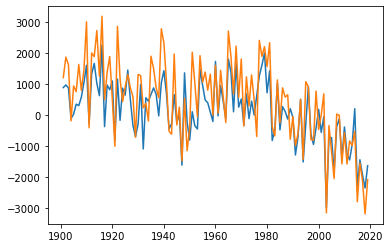

In [60]:
#rgi_reg='test'
#opath = os.path.join(sum_dir, 'fixed_geometry_mass_balance_{}.csv'.format(rgi_reg))
pd_fixed_geom = utils.compile_fixed_geometry_mass_balance(gdirs)
plt.plot(pd_fixed_geom)

### 3. Ice thickness inversion

- we need to make sure that we use the right prcp. fac here ! 


In [61]:
# inside of OGGM: 
#from oggm.core.massbalance import MultipleFlowlineMassBalance
#mb_model = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True)
#try:
#    pf = gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']
#    mb_model.prcp_fac = pf
#except KeyError:
#    pass

workflow.execute_entity_task(tasks.apparent_mb_from_any_mb, gdirs)

2022-07-07 11:14:15: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 2 glaciers


[None, None]

In [62]:
from oggm.core.massbalance import MultipleFlowlineMassBalance, PastMassBalance

In [63]:
# Inversion: we match the consensus
border = 80
filter = border >= 20

if border >= 20:
    task_list = [
        tasks.compute_downstream_line,
        tasks.compute_downstream_bedshape,
    ]
    for task in task_list:
        workflow.execute_entity_task(task, gdirs)

for gdir in gdirs:
    workflow.calibrate_inversion_from_consensus([gdir],
                                                apply_fs_on_mismatch=True,
                                                error_on_mismatch=False,
                                                filter_inversion_output=filter)

2022-07-07 11:14:15: oggm.workflow: Execute entity tasks [compute_downstream_line] on 2 glaciers
2022-07-07 11:14:15: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 2 glaciers
2022-07-07 11:14:15: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2022-07-07 11:14:16: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2022-07-07 11:14:16: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2022-07-07 11:14:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2022-07-07 11:14:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2022-07-07 11:14:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2022-07-07 11:14:16: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2022-07-07 11:14:16: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2022-07-07 11:14:16: oggm.w

In [64]:
# We get ready for modelling
if border >= 20:
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)
else:
    log.workflow('L3: for map border values < 20, wont initialize glaciers '
                 'for the run.')

2022-07-07 11:14:20: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 2 glaciers


In [65]:
rgi_reg = 'test'

In [66]:
opath = os.path.join(sum_dir, 'glacier_statistics_{}.csv'.format(rgi_reg))
glacier_stats = utils.compile_glacier_statistics(gdirs, path=opath)
opath = os.path.join(sum_dir, 'climate_statistics_{}.csv'.format(rgi_reg))
clim_stats = utils.compile_climate_statistics(gdirs, path=opath) #, winter_daily_mean_prcp = True)


2022-07-07 11:14:20: oggm.utils: Applying global task compile_glacier_statistics on 2 glaciers
2022-07-07 11:14:20: oggm.workflow: Execute entity tasks [glacier_statistics] on 2 glaciers
2022-07-07 11:14:20: oggm.utils: Applying global task compile_climate_statistics on 2 glaciers
2022-07-07 11:14:20: oggm.workflow: Execute entity tasks [climate_statistics] on 2 glaciers


In [67]:
gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']


1.7765151972292408

---

## Start of Level 5 tasks

In [29]:
from oggm.core.flowline import FluxBasedModel

evolution_model = FluxBasedModel

y0 = 1901 #79  # this is where the W5E5 climate dataset begins
ye = 2019  # and ends

for gdir in gdirs:
    pf = gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']
    tasks.run_from_climate_data(gdir,
                             min_ys=y0, ye=ye,
                             evolution_model=evolution_model,
                             output_filesuffix='_historical_givepf',
                               precipitation_factor=pf)
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                         min_ys=y0, ye=ye,
                         evolution_model=evolution_model,
                         output_filesuffix='_historical')  # gets pf automatically from the json file (actually should give the same result!!!)

2022-07-07 10:14:39: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2 glaciers


In [68]:
opath = os.path.join(sum_dir, f'historical_run_output_{rgi_reg}.nc')

ds_hist = utils.compile_run_output(gdirs, path=opath, input_filesuffix='_historical')
ds_hist_test = utils.compile_run_output(gdirs, path=opath, input_filesuffix='_historical_givepf')

# check if they are the same: ok, it works!
assert np.all(ds_hist.volume == ds_hist_test.volume) 

2022-07-07 11:17:32: oggm.utils: Applying global task compile_run_output on 2 glaciers
2022-07-07 11:17:32: oggm.utils: Applying compile_run_output on 2 gdirs.
2022-07-07 11:17:32: oggm.utils: Applying global task compile_run_output on 2 glaciers
2022-07-07 11:17:32: oggm.utils: Applying compile_run_output on 2 gdirs.


Text(0.5, 1.0, 'RGI60-11.00897')

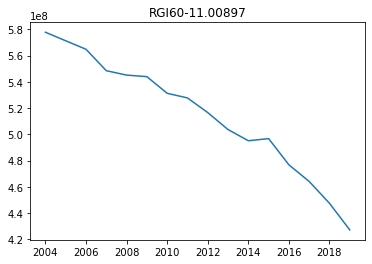

In [35]:
plt.plot(ds_hist.calendar_year, ds_hist.volume.isel(rgi_id=0))
plt.title(ds_hist.isel(rgi_id=0).rgi_id.values)

Text(0.5, 1.0, 'RGI60-11.01450')

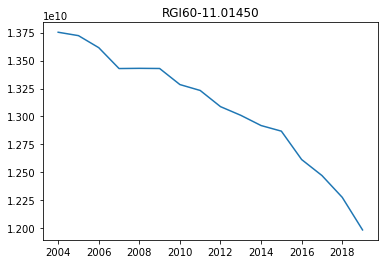

In [36]:
plt.plot(ds_hist.calendar_year, ds_hist.volume.isel(rgi_id=-1))
plt.title(ds_hist.isel(rgi_id=-1).rgi_id.values)

If we use as baseline_climate `W5E5` or `GSWP3_W5E5`, we do not need to do any bias correction, when we use the climate data from ISIMIP3b. This is because ISIMIP3b was internally bias-corrected to `W5E5` (add link). 

In [37]:
ssp = 'ssp126'  # 'ssp585' #126'
ensemble = 'mri-esm2-0_r1i1p1f1'
fs = '_monthly_ISIMIP3b_{}_{}'.format(ensemble, ssp)
workflow.execute_entity_task(tasks.process_monthly_isimip_data, gdirs, ensemble=ensemble, ssp=ssp, output_filesuffix=fs)
# this is the processed 
xr.open_dataset(gdir.get_filepath('gcm_data', filesuffix=fs))

2022-07-07 10:19:48: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 2 glaciers


<xarray.Dataset>
Dimensions:  (time: 3012)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2100-12-01
Data variables:
    prcp     (time) float32 ...
    temp     (time) float32 ...
Attributes:
    ref_hgt:         1764.0
    ref_pix_lon:     8.25
    ref_pix_lat:     46.75
    ref_pix_dis:     32652.873631988525
    climate_source:  _monthly_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126_no_OGGM_bia...
    hydro_yr_0:      1850
    hydro_yr_1:      2100
    author:          OGGM
    author_info:     Open Global Glacier Model

### Do projection run with isimip3b data


In [38]:
y0 = 1850 #79  # this is where the W5E5 climate dataset begins
ye = 2100  # and ends
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             min_ys=y0, ye=ye,
                             evolution_model=evolution_model,
                                climate_filename='gcm_data',
                                climate_input_filesuffix=fs,
                             output_filesuffix=f'_gcm_{fs}')


2022-07-07 10:20:17: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2 glaciers


In [75]:
gdir.read_json('local_mustar')

{'rgi_id': 'RGI60-11.01450',
 't_star': nan,
 'bias': 0,
 'mu_star_per_flowline': [303.6193835683732],
 'mu_star_glacierwide': 303.6193835683732,
 'mu_star_flowline_avg': 303.6193835683732,
 'mu_star_allsame': True,
 'prcp_fac_from_winter_prcp': 1.7765151972292408}

2022-07-07 10:20:35: oggm.utils: Applying global task compile_run_output on 2 glaciers
2022-07-07 10:20:35: oggm.utils: Applying compile_run_output on 2 gdirs.


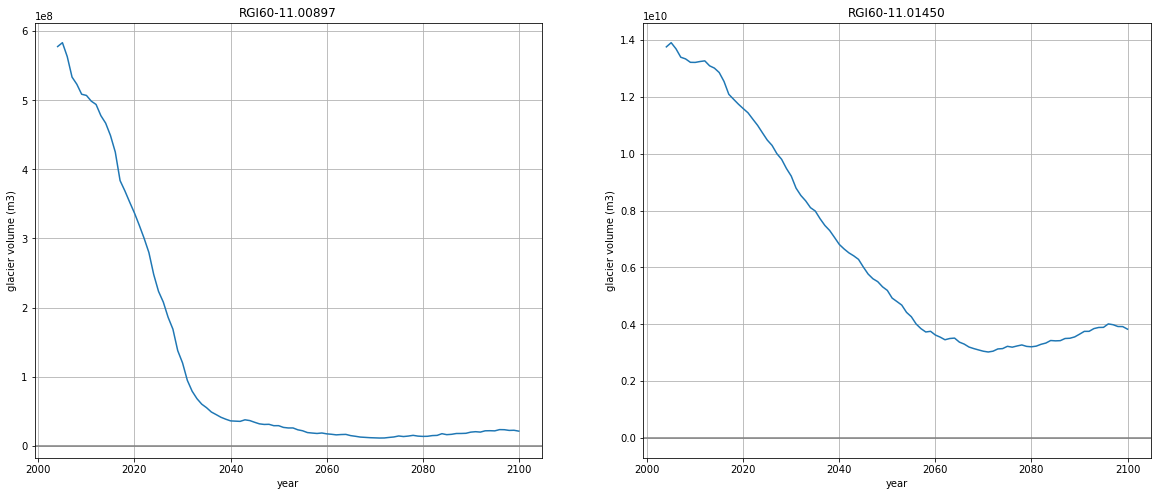

In [39]:
opath = os.path.join(sum_dir, f'gcm_run_output_{rgi_reg}.nc')

ds_gcm = utils.compile_run_output(gdirs, path=opath, input_filesuffix=f'_gcm_{fs}')

fig,axs = plt.subplots(1,2,figsize=(20,8)) #,sharey=True)
for j in [0,1]:
    axs[j].plot(ds_gcm.calendar_year, ds_gcm.volume.isel(rgi_id=j ))
    axs[j].set_title(ds_gcm.isel(rgi_id=j).rgi_id.values)
    axs[j].axhline(0, color='grey')
    axs[j].grid()
    axs[j].set_ylabel('glacier volume (m3)')
    axs[j].set_xlabel('year')

### Compare fixed geometry mass-balance from observational climate dataset to ISIMIP3b:

In [48]:
pd_fixed_geom= utils.compile_fixed_geometry_mass_balance(gdirs, climate_filename='climate_historical', climate_input_filesuffix='')
pd_fixed_geom_gcm= utils.compile_fixed_geometry_mass_balance(gdirs, climate_filename='gcm_data', climate_input_filesuffix=fs)

2022-07-07 10:55:40: oggm.utils: Applying global task compile_fixed_geometry_mass_balance on 2 glaciers
2022-07-07 10:55:40: oggm.workflow: Execute entity tasks [fixed_geometry_mass_balance] on 2 glaciers
2022-07-07 10:55:40: oggm.utils: Applying global task compile_fixed_geometry_mass_balance on 2 glaciers
2022-07-07 10:55:40: oggm.workflow: Execute entity tasks [fixed_geometry_mass_balance] on 2 glaciers


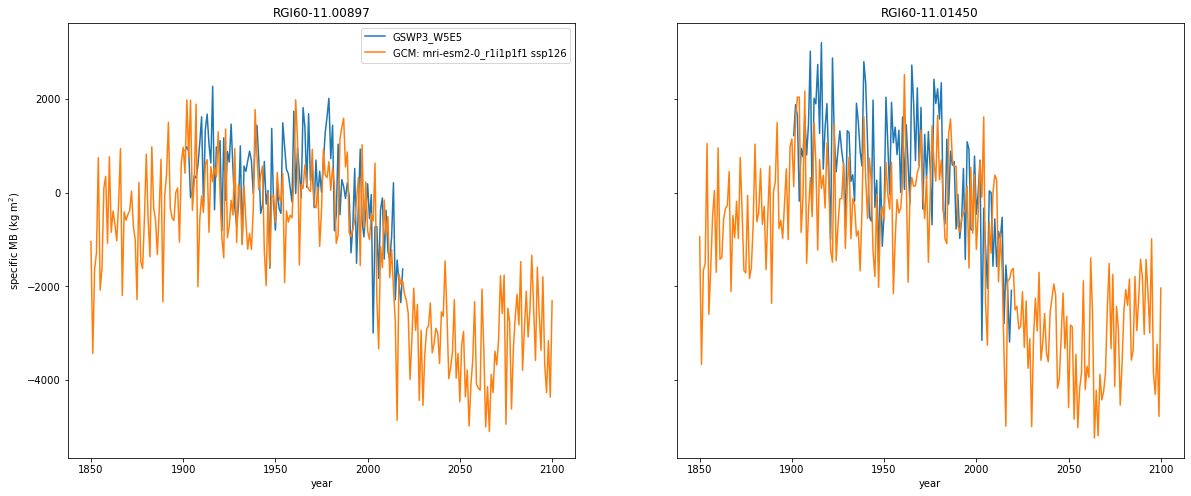

In [49]:
#rgi_reg='test'
#opath = os.path.join(sum_dir, 'fixed_geometry_mass_balance_{}.csv'.format(rgi_reg))
fig,axs = plt.subplots(1,2,figsize=(20,8),sharey=True)
for j,gdir in enumerate(gdirs):
    axs[j].plot(pd_fixed_geom[gdir.rgi_id], label = 'GSWP3_W5E5')
    axs[j].plot(pd_fixed_geom_gcm[gdir.rgi_id], label = f'GCM: {ensemble} {ssp}')
    if j == 0:
        axs[j].legend()
        axs[j].set_ylabel(r'specific MB (kg m$^{2}$)')
    axs[j].set_title(gdir.rgi_id)
    axs[j].set_xlabel('year')

TODO: 
- add mu_star, prcp_fac to run_from_climate output files?


## Other stuff from prepro level that is not so important for the notebook example workflow probably

In [32]:
dynamic_spinup = False #'volume' #False
dynamic_spinup_start_year = 1901




In [33]:
# Which model?
if evolution_model == 'massredis':
    from oggm.core.flowline import MassRedistributionCurveModel
    evolution_model = MassRedistributionCurveModel
else:
    from oggm.core.flowline import FluxBasedModel
    evolution_model = FluxBasedModel

# OK - run
if dynamic_spinup:
    if y0 > dynamic_spinup_start_year:
        dynamic_spinup_start_year = y0
    workflow.execute_entity_task(tasks.run_dynamic_spinup, gdirs,
                                 evolution_model=evolution_model,
                                 minimise_for=dynamic_spinup,
                                 spinup_start_yr=dynamic_spinup_start_year,
                                 output_filesuffix='_dynamic_spinup',
                                 )
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                 min_ys=y0, ye=ye,
                                 evolution_model=evolution_model,
                                 init_model_filesuffix='_dynamic_spinup',
                                 output_filesuffix='_hist_spin')
    workflow.execute_entity_task(tasks.merge_consecutive_run_outputs, gdirs,
                                 input_filesuffix_1='_dynamic_spinup',
                                 input_filesuffix_2='_hist_spin',
                                 output_filesuffix='_historical_spinup',
                                 delete_input=True)

workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             min_ys=y0, ye=ye,
                             evolution_model=evolution_model,
                             output_filesuffix='_historical') 

2022-05-17 17:10:42: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2 glaciers


In [34]:


if dynamic_spinup:
    opath = os.path.join(sum_dir, f'historical_spinup_run_output_{rgi_reg}.nc')
    ds_hist_spinup = utils.compile_run_output(gdirs, path=opath,
                             input_filesuffix='_historical_spinup')

2022-05-17 17:10:43: oggm.utils: Applying global task compile_run_output on 2 glaciers
2022-05-17 17:10:43: oggm.utils: Applying compile_run_output on 2 gdirs.


In [35]:
plt.plot(ds_hist_spinup.calendar_year, ds_hist_spinup.volume.isel(rgi_id=1))
plt.title(ds_hist_spinup.isel(rgi_id=1).rgi_id.values)

NameError: name 'ds_hist_spinup' is not defined